In [2]:
from copy import copy
from sympy import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as MSE

In [15]:
N = 30
q = 1
T = 5000

b = 80
C = 1
D = C*np.sqrt(b)
L = C*b
G = C*np.sqrt(b**3)

alphas = [(C*b)/np.sqrt(np.sum([((4*np.pi**2)**k)*((j/2)**(2*k)) for k in range(3)])) for j in range(2*N + 1)]
D_2m = sum(4*alphas)

alpha = np.sqrt(2/(T*(G**2)*(D**2)))
M = int(np.ceil(0.5*np.log2(1 + 4*T/7)) + 1)
eta = (((2**np.arange(0,M))*D)/G)*np.sqrt(7)/np.sqrt(2*T)

np.random.seed(0)

In [16]:
def join_arrs(a0, arr1, arr2):
    new_arr = np.zeros(len(arr1) + len(arr2))
    new_arr[::2] = arr1
    new_arr[1::2] = arr2
    new_arr = np.concatenate(([a0], new_arr))
    return new_arr

def solve_euler(h, q):
    t = symbols('t')
    x = Function('x')
    C1 = symbols('C1')
    C2 = symbols('C2')
    x = dsolve(- diff(x(t), t, t) + q**2*x(t) - h , x(t)).rhs
    cond1 = x.subs(t, 0) - x.subs(t, 1)
    cond2 = diff(x, t).subs(t, 0) - diff(x, t).subs(t, 1)
    solution = solve([cond1, cond2], [C1, C2])
    x = x.subs(C1, solution[C1]).subs(C2, solution[C2])
    return x

def pop_fourier_coefs(func):
    a0 =  np.trapezoid(func(np.linspace(0, 1, 100)), np.linspace(0, 1, 100))
    an = np.zeros(N)
    bn = np.zeros(N)

    for n in range(1, N+1):
        an[n-1] =  np.trapezoid(func(np.linspace(0, 1, 100)) * np.sqrt(2)*np.cos(n * 2*np.pi * np.linspace(0, 1, 100)), np.linspace(0, 1, 100))
        bn[n-1] =  np.trapezoid(func(np.linspace(0, 1, 100)) * np.sqrt(2)*np.sin(n * 2*np.pi * np.linspace(0, 1, 100)), np.linspace(0, 1, 100))

    return a0, an, bn

def fourier_series(t, a0, an, bn, N):
    return a0 + np.sum([an[n] * np.sqrt(2)*np.cos((n+1) * 2*np.pi * t) + bn[n] * np.sqrt(2)*np.sin((n+1) * 2*np.pi * t) for n in range(N)])


## $\psi$ = 1.5

In [17]:
# Initialize variables
k = np.arange(1, M+1)
p = np.zeros((T, M))
p[0] = (M+1)/(M * k * (k+1))  # Expert probabilities

w_experts = np.random.random((T, M, 2*N+1))  # Expert weights
w = np.zeros((T, 2*N+1))
w[0] = np.einsum('i,ij->j', p[0], w_experts[0])  # Initial combined weights

# Tracking variables
Regret_J_n, Regret_J_n_sqrt = [], []
Dif_J_n = []
grads = []

# System setup
psi = 1.5
t = symbols('t')
h = lambdify(t, 10*pi**2*cos(2*psi*pi*t))
x = lambdify(t, solve_euler(h_sp, q))

# Precompute Fourier coefficients
a0, an, bn = pop_fourier_coefs(x())
h_a0, h_an, h_bn = pop_fourier_coefs(h)
x_hat = join_arrs(a0, an, bn)
h_hat = join_arrs(h_a0, h_an, h_bn)

# Precompute common terms
ceil_j_sq = np.ceil(np.arange(2*N+1)/2)**2
freq_terms = (2*np.pi)**2 * ceil_j_sq
sqrt_alphas = np.sqrt(alphas)

# Vectorized functions
def gradient(w):
    return alphas * (q**2 + freq_terms) * w - sqrt_alphas * h_hat

def J_n(w):
    return 0.5*np.sum(alphas*(q**2 + freq_terms)*w**2) - np.sum(sqrt_alphas*h_hat*w)

# Main loop
for i in range(T-1):
    gradient_w = gradient(w[i])
    grads.append(gradient_w)

    # Update experts
    w_experts[i+1] = w_experts[i] - eta[:, None] * gradient_w

    # Update probabilities
    loss = np.einsum('j,ij->i', gradient_w, w_experts[i] - w[i])
    p[i+1] = np.exp(-alpha * loss)
    p[i+1] /= p[i+1].sum()

    # Update combined weights
    w[i+1] = np.einsum('i,ij->j', p[i+1], w_experts[i+1])

    # Track performance
    current_diff = J_n(w[i]) - J_n(x_hat/sqrt_alphas)
    Dif_J_n.append(current_diff)
    n = len(Dif_J_n)
    Regret_J_n_sqrt.append(sum(Dif_J_n)/np.sqrt(n))
    Regret_J_n.append(sum(Dif_J_n)/n)

In [18]:
np.abs(J_n(w[i]) - J_n(x_hat/np.sqrt(alphas)))

np.float64(7.578343544523136e-05)

In [19]:
Regret_J_n[-1]

np.float64(0.27123079322751653)

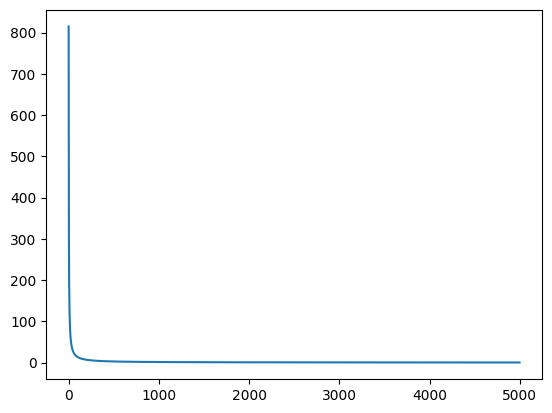

In [20]:
plt.plot(Regret_J_n)

## $\psi$ = N(0, 0.03)

In [ ]:
# Optimized probability initialization
k = np.arange(1, M+1)
p = np.zeros((T, M))
p[0] = (M+1)/(M * k * (k+1))  # Vectorized calculation

# Experts and aggregated weights initialization
w_experts = np.random.random((T, M, 2*N+1))  # Initialize all at once
w = np.zeros((T, 2*N+1))
w[0] = np.einsum('i,ij->j', p[0], w_experts[0])  # More efficient than reshape+sum

# Metrics storage
Regret_J_n, Regret_J_n_sqrt = [], []
Dif_J_n = []
grads = []
psi = np.random.normal(0, 0.03, T)
t = symbols('t')

# Precompute frequently used values
ceil_j_sq = np.ceil(np.arange(2*N+1)/2)**2
freq_terms = (2*np.pi)**2 * ceil_j_sq
sqrt_alphas = np.sqrt(alphas)

# Vectorized functions
def compute_gradient(w, h_hat):
    """Vectorized gradient computation"""
    return alphas * (q**2 + freq_terms) * w - sqrt_alphas * h_hat

def compute_J_n(w, h_hat):
    """Vectorized J_n computation"""
    term1 = 0.5 * np.sum(alphas * (q**2 + freq_terms) * w**2)
    term2 = np.sum(sqrt_alphas * h_hat * w)
    return term1 - term2

# Main loop
for i in range(T-1):
    # Symbolic computations
    h_sp = 10*pi**2*cos(2*psi[i]*pi*t)
    h = lambdify(t, h_sp)
    x_sp = solve_euler(h_sp, q)
    x = lambdify(t, x_sp)

    # Fourier coefficients
    a0, an, bn = pop_fourier_coefs(x)
    h_a0, h_an, h_bn = pop_fourier_coefs(h)

    x_hat = join_arrs(a0, an, bn)
    h_hat = join_arrs(h_a0, h_an, h_bn)

    # Gradient computation
    gradient_w = compute_gradient(w[i], h_hat)
    grads.append(gradient_w)

    # Update experts (vectorized)
    w_experts[i+1] = w_experts[i] - eta[:, np.newaxis] * gradient_w

    # Compute loss (vectorized)
    expert_diffs = w_experts[i] - w[i]
    loss = np.einsum('j,ij->i', gradient_w, expert_diffs)

    # Update probabilities (softmax)
    exp_loss = np.exp(-alpha * loss)
    p[i+1] = exp_loss / np.sum(exp_loss)

    # Update aggregated weights
    w[i+1] = np.einsum('i,ij->j', p[i+1], w_experts[i+1])

    # Update metrics
    current_diff = compute_J_n(w[i], h_hat) - compute_J_n(x_hat/sqrt_alphas, h_hat)
    Dif_J_n.append(current_diff)
    n = len(Dif_J_n)
    Regret_J_n_sqrt.append(np.sum(Dif_J_n)/np.sqrt(n))
    Regret_J_n.append(np.sum(Dif_J_n)/n)

In [ ]:
np.abs(J_n(w[i]) - J_n(x_hat/np.sqrt(alphas)))

In [ ]:
Regret_J_n[-1]

In [ ]:
plt.plot(Regret_J_n)

## $\psi$ = np.linspace(2, 3, T)

In [ ]:
# Optimized probability initialization
k = np.arange(1, M+1)
p = np.zeros((T, M))
p[0] = (M+1)/(M * k * (k+1))  # Vectorized calculation

# Experts and aggregated weights initialization
w_experts = np.random.random((T, M, 2*N+1))  # Initialize all at once
w = np.zeros((T, 2*N+1))
w[0] = np.einsum('i,ij->j', p[0], w_experts[0])  # More efficient than reshape+sum

# Metrics storage
Regret_J_n, Regret_J_n_sqrt = [], []
Dif_J_n = []
grads = []
psi = np.linspace(2, 3, T)
t = symbols('t')

# Precompute frequently used values
ceil_j_sq = np.ceil(np.arange(2*N+1)/2)**2
freq_terms = (2*np.pi)**2 * ceil_j_sq
sqrt_alphas = np.sqrt(alphas)

# Vectorized functions
def compute_gradient(w, h_hat):
    """Vectorized gradient computation"""
    return alphas * (q**2 + freq_terms) * w - sqrt_alphas * h_hat

def compute_J_n(w, h_hat):
    """Vectorized J_n computation"""
    term1 = 0.5 * np.sum(alphas * (q**2 + freq_terms) * w**2)
    term2 = np.sum(sqrt_alphas * h_hat * w)
    return term1 - term2

# Main loop
for i in range(T-1):
    # Symbolic computations
    h_sp = 10*pi**2*cos(2*psi[i]*pi*t)
    h = lambdify(t, h_sp)
    x_sp = solve_euler(h_sp, q)
    x = lambdify(t, x_sp)

    # Fourier coefficients
    a0, an, bn = pop_fourier_coefs(x)
    h_a0, h_an, h_bn = pop_fourier_coefs(h)

    x_hat = join_arrs(a0, an, bn)
    h_hat = join_arrs(h_a0, h_an, h_bn)

    # Gradient computation
    gradient_w = compute_gradient(w[i], h_hat)
    grads.append(gradient_w)

    # Update experts (vectorized)
    w_experts[i+1] = w_experts[i] - eta[:, np.newaxis] * gradient_w

    # Compute loss (vectorized)
    expert_diffs = w_experts[i] - w[i]
    loss = np.einsum('j,ij->i', gradient_w, expert_diffs)

    # Update probabilities (softmax)
    exp_loss = np.exp(-alpha * loss)
    p[i+1] = exp_loss / np.sum(exp_loss)

    # Update aggregated weights
    w[i+1] = np.einsum('i,ij->j', p[i+1], w_experts[i+1])

    # Update metrics
    current_diff = compute_J_n(w[i], h_hat) - compute_J_n(x_hat/sqrt_alphas, h_hat)
    Dif_J_n.append(current_diff)
    n = len(Dif_J_n)
    Regret_J_n_sqrt.append(np.sum(Dif_J_n)/np.sqrt(n))
    Regret_J_n.append(np.sum(Dif_J_n)/n)

In [ ]:
np.abs(J_n(w[i]) - J_n(x_hat/np.sqrt(alphas)))

In [ ]:
Regret_J_n[-1]

In [ ]:
plt.plot(Regret_J_n)

## $\psi$ = [0.5]*int(T/2) + [1.5]*int(T/2)

In [ ]:
# Optimized probability initialization
k = np.arange(1, M+1)
p = np.zeros((T, M))
p[0] = (M+1)/(M * k * (k+1))  # Vectorized calculation

# Experts and aggregated weights initialization
w_experts = np.random.random((T, M, 2*N+1))  # Initialize all at once
w = np.zeros((T, 2*N+1))
w[0] = np.einsum('i,ij->j', p[0], w_experts[0])  # More efficient than reshape+sum

# Metrics storage
Regret_J_n, Regret_J_n_sqrt = [], []
Dif_J_n = []
grads = []
psi = [0.5]*int(T/2) + [1.5]*int(T/2)
t = symbols('t')

# Precompute frequently used values
ceil_j_sq = np.ceil(np.arange(2*N+1)/2)**2
freq_terms = (2*np.pi)**2 * ceil_j_sq
sqrt_alphas = np.sqrt(alphas)

# Vectorized functions
def compute_gradient(w, h_hat):
    """Vectorized gradient computation"""
    return alphas * (q**2 + freq_terms) * w - sqrt_alphas * h_hat

def compute_J_n(w, h_hat):
    """Vectorized J_n computation"""
    term1 = 0.5 * np.sum(alphas * (q**2 + freq_terms) * w**2)
    term2 = np.sum(sqrt_alphas * h_hat * w)
    return term1 - term2

# Main loop
for i in range(T-1):
    # Symbolic computations
    h_sp = 10*pi**2*cos(2*psi[i]*pi*t)
    h = lambdify(t, h_sp)
    x_sp = solve_euler(h_sp, q)
    x = lambdify(t, x_sp)

    # Fourier coefficients
    a0, an, bn = pop_fourier_coefs(x)
    h_a0, h_an, h_bn = pop_fourier_coefs(h)

    x_hat = join_arrs(a0, an, bn)
    h_hat = join_arrs(h_a0, h_an, h_bn)

    # Gradient computation
    gradient_w = compute_gradient(w[i], h_hat)
    grads.append(gradient_w)

    # Update experts (vectorized)
    w_experts[i+1] = w_experts[i] - eta[:, np.newaxis] * gradient_w

    # Compute loss (vectorized)
    expert_diffs = w_experts[i] - w[i]
    loss = np.einsum('j,ij->i', gradient_w, expert_diffs)

    # Update probabilities (softmax)
    exp_loss = np.exp(-alpha * loss)
    p[i+1] = exp_loss / np.sum(exp_loss)

    # Update aggregated weights
    w[i+1] = np.einsum('i,ij->j', p[i+1], w_experts[i+1])

    # Update metrics
    current_diff = compute_J_n(w[i], h_hat) - compute_J_n(x_hat/sqrt_alphas, h_hat)
    Dif_J_n.append(current_diff)
    n = len(Dif_J_n)
    Regret_J_n_sqrt.append(np.sum(Dif_J_n)/np.sqrt(n))
    Regret_J_n.append(np.sum(Dif_J_n)/n)

In [ ]:
np.abs(J_n(w[i]) - J_n(x_hat/np.sqrt(alphas)))

In [ ]:
Regret_J_n[-1]

In [ ]:
plt.plot(Regret_J_n)

## $\psi$ = np.linspace(2, 3, T) + np.random.normal(0, 0.03, T)

In [ ]:
# Optimized probability initialization
k = np.arange(1, M+1)
p = np.zeros((T, M))
p[0] = (M+1)/(M * k * (k+1))  # Vectorized calculation

# Experts and aggregated weights initialization
w_experts = np.random.random((T, M, 2*N+1))  # Initialize all at once
w = np.zeros((T, 2*N+1))
w[0] = np.einsum('i,ij->j', p[0], w_experts[0])  # More efficient than reshape+sum

# Metrics storage
Regret_J_n, Regret_J_n_sqrt = [], []
Dif_J_n = []
grads = []
psi = np.linspace(2, 3, T) + np.random.normal(0, 0.03, T)
t = symbols('t')

# Precompute frequently used values
ceil_j_sq = np.ceil(np.arange(2*N+1)/2)**2
freq_terms = (2*np.pi)**2 * ceil_j_sq
sqrt_alphas = np.sqrt(alphas)

# Vectorized functions
def compute_gradient(w, h_hat):
    """Vectorized gradient computation"""
    return alphas * (q**2 + freq_terms) * w - sqrt_alphas * h_hat

def compute_J_n(w, h_hat):
    """Vectorized J_n computation"""
    term1 = 0.5 * np.sum(alphas * (q**2 + freq_terms) * w**2)
    term2 = np.sum(sqrt_alphas * h_hat * w)
    return term1 - term2

# Main loop
for i in range(T-1):
    # Symbolic computations
    h_sp = 10*pi**2*cos(2*psi[i]*pi*t)
    h = lambdify(t, h_sp)
    x_sp = solve_euler(h_sp, q)
    x = lambdify(t, x_sp)

    # Fourier coefficients
    a0, an, bn = pop_fourier_coefs(x)
    h_a0, h_an, h_bn = pop_fourier_coefs(h)

    x_hat = join_arrs(a0, an, bn)
    h_hat = join_arrs(h_a0, h_an, h_bn)

    # Gradient computation
    gradient_w = compute_gradient(w[i], h_hat)
    grads.append(gradient_w)

    # Update experts (vectorized)
    w_experts[i+1] = w_experts[i] - eta[:, np.newaxis] * gradient_w

    # Compute loss (vectorized)
    expert_diffs = w_experts[i] - w[i]
    loss = np.einsum('j,ij->i', gradient_w, expert_diffs)

    # Update probabilities (softmax)
    exp_loss = np.exp(-alpha * loss)
    p[i+1] = exp_loss / np.sum(exp_loss)

    # Update aggregated weights
    w[i+1] = np.einsum('i,ij->j', p[i+1], w_experts[i+1])

    # Update metrics
    current_diff = compute_J_n(w[i], h_hat) - compute_J_n(x_hat/sqrt_alphas, h_hat)
    Dif_J_n.append(current_diff)
    n = len(Dif_J_n)
    Regret_J_n_sqrt.append(np.sum(Dif_J_n)/np.sqrt(n))
    Regret_J_n.append(np.sum(Dif_J_n)/n)

In [ ]:
np.abs(J_n(w[i]) - J_n(x_hat/np.sqrt(alphas)))

In [ ]:
Regret_J_n[-1]

In [ ]:
plt.plot(Regret_J_n)